# Setup

In [1]:
# This code chunk can be removed in the final notebook since the requirements.txt file lists all used packages!
!pip install requests openpyxl PyMuPDF glob2 nltk spacy pandas gensim Counter matplotlib seaborn wordcloud pmdarima statsmodels

  Created wheel for Counter: filename=Counter-1.0.0-py3-none-any.whl size=5414 sha256=7932e313f5225e4a6425d9b09e47dabdf23cb4a9c747a4b48107e479299e872c
  Stored in directory: c:\users\balazs\appdata\local\pip\cache\wheels\05\78\ee\7f4336de4d2631224a4b303be03e48eeb01db89bb5bd790f5d
Successfully built Counter


ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

pmdarima 1.8.5 requires statsmodels!=0.12.0,>=0.11, but you'll have statsmodels 0.12.0 which is incompatible.


In [2]:
# accessing APIs and URLs
import requests

# static web scraping
from urllib.request import urlopen
from lxml.html import parse, fromstring

# regular expressions
import re

# downloading files
import urllib.request

# operating system
import os

# looping through folder
import glob

# reading pdfs
import fitz 

# disabling warnings
import warnings

# nltk
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# nlp
import spacy

# data wrangling
import pandas as pd

# topic modelling
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel

# counting words
from collections import Counter

# data viz
import matplotlib.pyplot as plt

# grahps
import seaborn as sns

# word cloud
from wordcloud import WordCloud

# centering plots
from IPython.core.display import HTML

# merging multiple data frames
from functools import reduce

# automated time series analysis
import pmdarima as pm

# ARIMA
from statsmodels.tsa.arima.model import ARIMA

# ignoring warnings
warnings.filterwarnings('ignore')

In [3]:
# download trained pipeline for the English language
!python3 -m spacy download en_core_web_sm

# download dictionary
nltk.download('omw-1.4')
nltk.download('wordnet')

Python was not found; run without arguments to install from the Microsoft Store, or disable this shortcut from Settings > Manage App Execution Aliases.
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Balazs\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\omw-1.4.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Balazs\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
# center plots
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# Data Collection and Import

In [5]:
# extract all links from website
tree = parse(urlopen("https://www.americanrhetoric.com/barackobamaspeeches.htm"))
linkelements = tree.xpath("//a")
list_links = [e.attrib["href"] for e in linkelements]

In [6]:
print("Number of links: " + str(len(list_links)))

Number of links: 1417


In [7]:
# only retain pdf links
p = re.compile('.*pdf$')
pdf_links = [ s for s in list_links if p.match(s) ]

In [8]:
print("Number of pdf links: " + str(len(pdf_links)))

Number of pdf links: 436


In [9]:
# concetenate baseurl and path
baseurl = "https://www.americanrhetoric.com/"
full_pdf_links = [baseurl + link for link in pdf_links]

In [10]:
# create new folder
folder_name = "obama_speeches"
os.makedirs(folder_name, exist_ok = True)

In [11]:
# download all pdf files
def download_files(links, folder):
    i = 1
    for link in links:
        filename = folder + "/file_" + str(i) + ".pdf"
        
        # check if file already exists and, if so, continue
        if os.path.isfile(filename):
            continue
            
        # otherwise download file and save in folder
        else: 
            urllib.request.urlretrieve(link, filename)
        
        i = i + 1

In [12]:
download_files(full_pdf_links, folder_name)

In [13]:
# import files
def import_pdfs(folder):
    
    # sort pdf files by name
    numbers = re.compile(r'(\d+)')
    def numericalSort(value):
        parts = numbers.split(value)
        parts[1::2] = map(int, parts[1::2])
        return parts
    filename_list = sorted(glob.glob(folder + "/*.pdf"), key = numericalSort)
    
    # create empty list
    speech = []
    
    # loop through all files
    for filename in filename_list:
        with fitz.open(filename) as doc:
            text = ""
            for page in doc:
                text += page.get_text()
        speech.append(text)
        
    return speech

In [14]:
list_speeches = import_pdfs(folder_name)

# Data Pre-Processing

## Noise Removal

In [15]:
# noise removal and standardisation
def noise_removal(texts):
    no_noise = []
    for text in texts:
        
        # separate line breaks from words
        p1 = re.compile(r'(\n)([A-Za-z\\[])') 
        text = re.sub(p1, r"\1 \2", text) 
        p2 = re.compile(r'([A-Za-z])(\n)') 
        text = re.sub(p2, r"\1 \2", text)
        
        # remove footer
        text = re.sub('(AAm|AmericanRhetoric\.com)\s((.||\n)*?)\sPage\s\d{1,2}', '', text)
        text = re.sub('(meerriiccaannR)\s((.||\n)*?)\s(Property)', '', text)
        
        # remove everything up until (and including) the sentence with the date of the speech
        text = re.sub(r'^((.|\n)*)\s(\d{1,2}\s{1,2}[a-zA-Z]{3,9},?\s\d{4},?)\s.*\s\n', '', text)  
        
        # remove everything up until (and including) the statement about transcription
        text = re.sub('^((.|\n)*)\s(\\[?AUTHENTICITY)\s.*\s\n', '', text)  
        
        # remove line breaks
        text = re.sub("\n", "", text) 
        
        # remove multiple white spaces
        text = re.sub("\s+", " ", text) 
        
        # lower case
        text = text.lower() 
        
        # remove punctuation and most special characters
        text = re.sub("[^a-zA-Z\d\s/]", "", text)
        no_noise.append(text)
        
    return no_noise

In [16]:
no_noise = noise_removal(list_speeches)

In [17]:
# stopword removal
stop_words = stopwords.words("english")
no_stopwords = [[word for word in word_tokenize(text) if word not in stop_words] for text in no_noise]

## N-Grams

In [18]:
# create n-grams
def n_grams(texts, min_count, threshold):
    
    # setup
    bigram = gensim.models.Phrases(texts, min_count = min_count, threshold = threshold)
    trigram = gensim.models.Phrases(bigram[texts], threshold = threshold)  
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)

    # add bigrams
    n_grams = [bigram_mod[doc] for doc in texts]

    # add trigrams
    n_grams = [trigram_mod[bigram_mod[doc]] for doc in texts]
    
    return n_grams

In [19]:
bigrams_trigrams = n_grams(no_stopwords, 5, 100)

## Text Normalisation

In [20]:
# text normalisation with pos tags
def text_normalisation(texts):
    nlp = spacy.load('en_core_web_sm', disable = ['parser', 'ner'])
    postags = ['NOUN', 'ADJ', 'VERB', 'ADV']
    normalised_data = []

    for word in texts:
            doc = nlp(" ".join(word)) 
            normalised_data.append([token.lemma_ for token in doc if token.pos_ in postags])
    
    return normalised_data

In [21]:
normalised_data = text_normalisation(bigrams_trigrams)

## Removal of Low and High Frequency Words

In [22]:
# compute vocabulary size
def count_words(texts):
    count_words = Counter([i for sublist in texts for i in sublist])
    return count_words

def print_vocab_size(texts):
    print("Total Vocabulary Size: " + str(len(texts)))

In [23]:
count_words_pre_cleaning = count_words(normalised_data)
print_vocab_size(count_words_pre_cleaning)

Total Vocabulary Size: 20737


In [24]:
# compute word frequencies
dict_df = pd.DataFrame.from_dict(count_words_pre_cleaning, orient = 'index', columns = ['freq'])
dict_df['perc'] = (dict_df['freq'] / dict_df['freq'].sum()) * 100
dict_df.sort_values('perc', ascending = False).head(15).round(2)

,freq,perc
people,7482,1.15
s,7460,1.14
make,6717,1.03
go,6709,1.03
ve,6256,0.96
get,5913,0.91
do,4768,0.73
work,4584,0.70
say,4380,0.67
american,4195,0.64


In [25]:
# add low and high frequency words to stop_words
min_freq = 20; max_freq = 2300
extension = dict_df[(dict_df.freq <= min_freq) | (dict_df.freq >= max_freq)].index.tolist()
extension = extension + ["lot", "thing", "let", "use", "sure", "look", "tell", "many", "much", "thank"]
stop_words.extend(extension)

# remove stopwords
stop_words_extended = set(stop_words)
cleaned_data = [[token for token in text if token not in stop_words_extended] for text in normalised_data]

# compute vocabulary size
count_words_post_cleaning = count_words(cleaned_data)
print_vocab_size(count_words_post_cleaning)

Total Vocabulary Size: 3220


In [26]:
# create term document frequency
id2word = corpora.Dictionary(cleaned_data)
corpus = [id2word.doc2bow(text) for text in cleaned_data]

# Topic Modelling

## Determining the Number of Topics

In [27]:
# 'elbow' method
def coherence_values(corpus, id2word, start, limit, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus = corpus, id2word = id2word, num_topics = num_topics, 
                                          random_state = 100, update_every = 1, chunksize = 100, 
                                          passes = 10, alpha = 'auto', per_word_topics = True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model = model, texts = cleaned_data, dictionary = id2word, 
                                        coherence = 'c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return coherence_values

In [28]:
start = 2; limit = 20; step = 2
coherence_values = coherence_values(corpus, id2word, start, limit, step)

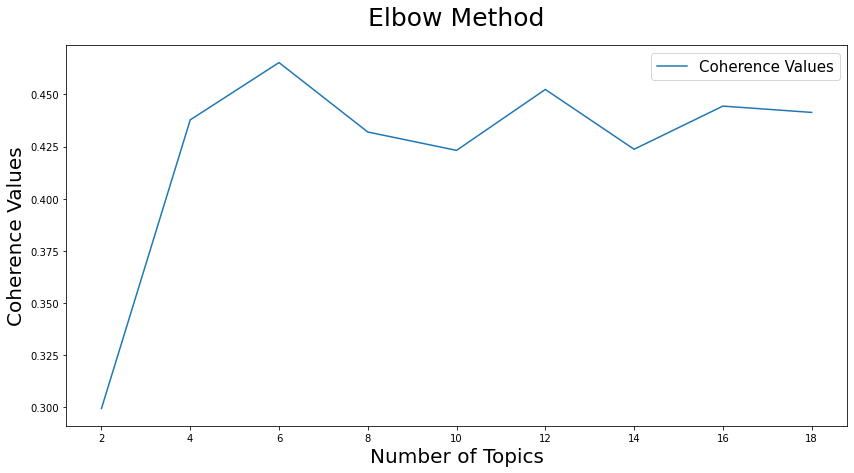

In [29]:
# plot results
plt.rcParams['figure.figsize'] = [14, 7]
x = range(start, limit, step)
plt.plot(x, coherence_values, label = "Coherence Values")
plt.xlabel("Number of Topics", fontsize = 20)
plt.ylabel("Coherence Values", fontsize = 20)
plt.legend(loc="upper right", fontsize = 15)
plt.title('Elbow Method', fontsize = 25, pad = 20)
plt.show()

In [30]:
# examine coherence values
for number_topics, cv in zip(x, coherence_values):
    print(number_topics, 'topics have a coherence value of', round(cv, 3))

2 topics have a coherence value of 0.299
4 topics have a coherence value of 0.438
6 topics have a coherence value of 0.465
8 topics have a coherence value of 0.432
10 topics have a coherence value of 0.423
12 topics have a coherence value of 0.452
14 topics have a coherence value of 0.424
16 topics have a coherence value of 0.444
18 topics have a coherence value of 0.441


Based on the coherence values, 8 topics seem to be the best choice for our data. However, a coherence value of 0.462 is rather low, so maybe more pre-processing is needed?

## Latent Dirichlet Allocation

In [31]:
# build topic model
number_topics = 8
topic_model_lda = gensim.models.ldamodel.LdaModel(corpus = corpus, id2word = id2word, num_topics = number_topics, 
                                                  random_state = 100, update_every = 1, chunksize = 100, 
                                                  passes = 14, alpha = 'auto', per_word_topics = True)

In [32]:
# compute perplexity
print('Perplexity: ', round(topic_model_lda.log_perplexity(corpus), 3))

# compute coherence value
coherence_topic_model_lda = CoherenceModel(model = topic_model_lda, texts = cleaned_data, dictionary = id2word, 
                                           coherence = 'c_v')
coherence_topic_model_lda_values = coherence_topic_model_lda.get_coherence()
print('Coherence Value: ', round(coherence_topic_model_lda_values, 3))

Perplexity:  -7.199
Coherence Value:  0.429


interpretation??

In [33]:
# create data frame of topics with corresponding keywords
lda_topics = [[(term, round(weight, 3)) for term, weight in topic_model_lda.show_topic(n, topn = 20)] 
              for n in range(0, topic_model_lda.num_topics)]
lda_topics_df = pd.DataFrame([', '.join([term for term, weight in topic]) 
                              for topic in lda_topics], columns = ['keywords'],
                             index = ['topic_' + str(t) for t in range(1, topic_model_lda.num_topics + 1)] )

In [34]:
# replace generic index with topic names
index_names = lda_topics_df.index.values.tolist()
topic_names = ["defence", "national pride", "labour market", "health care", "financial sector", 
               "support system", "future", "political ambitions"]
lda_topics_df = lda_topics_df.rename(index = dict(zip(index_names, topic_names)))

In [35]:
# print data frame
pd.set_option('display.max_colwidth', 0)
lda_topics_df

,keywords
defence,"question, president_obama, issue, try, good, president, important, able, happen, part, really, fact, start, talk, problem, give, point, election, even, still"
national pride,"isil, military, iraq, terrorist, attack, war, troop, fight, force, continue, support, afghanistan, syria, effort, include, government, threat, protect, security, today"
labour market,"life, day, family, today, love, give, man, never, faith, live, story, stand, serve, together, war, heart, great, even, hope, generation"
health care,"job, economy, pay, business, plan, health_care, cost, company, reform, good, government, family, put, worker, money, even, create, congress, system, keep"
financial sector,"democracy, young, believe, government, united_state, together, future, opportunity, leader, today, live, change, progress, history, great, citizen, power, build, economy, child"
support system,"forum, leverage, link, multilateral, jim, killer, fourth, confident, familiar, endanger, empower, effectively, effective, diplomatic, dark, corruption, cop, grave, complete, inspector"
future,"family, good, community, change, young, woman, child, today, kid, life, day, happen, job, love, school, give, man, great, hard, keep"
political ambitions,"iran, russia, continue, united_state, security, international, region, china, strong, cooperation, issue, deal, economy, europe, today, sanction, include, support, president, together"


In [36]:
# reset display settings
pd.reset_option('^display.', silent = True)

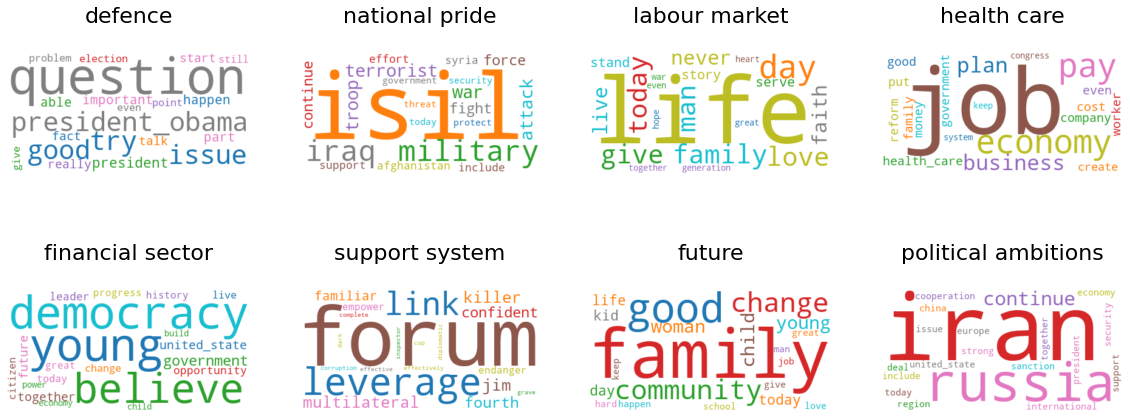

In [37]:
# plot settings
wc = WordCloud(background_color = "white", colormap = "tab10",
               max_font_size = 150, random_state = 42)
plt.rcParams['figure.figsize'] = [20, 8]

# create wordcloud for each topic
for i in range(topic_model_lda.num_topics):
    wc.generate(text = lda_topics_df["keywords"][i])
    plt.subplot(2, 4, i + 1)
    plt.imshow(wc, interpolation = "bilinear")
    plt.axis("off")
    plt.title(lda_topics_df.index[i], fontsize = 22, y = 1.2)

## Topic Distribution by Years

In [38]:
# extract distribution of topics by speech
topic_distribution_speeches = [topic_model_lda.get_document_topics(item, 
                                                                   minimum_probability = 0.0) for item in corpus]

In [39]:
# create data frame of topic distributions by speech
lda_df_proportions = pd.DataFrame.from_records([{v: k for v, k in row} for row in topic_distribution_speeches])
lda_df_proportions.columns = topic_names
lda_df_proportions['file'] = lda_df_proportions.reset_index().index + 1
lda_df_proportions = lda_df_proportions.set_index('file')

In [40]:
# create data frame of speeches
d = {'speech': list_speeches}
speeches_df = pd.DataFrame(d)

# add file name
speeches_df['file'] = speeches_df.reset_index().index + 1
speeches_df = speeches_df.set_index('file')

# extract dates of speeches
date_reg = r'(\d{1,2}\s{1,2}[a-zA-Z]{3,9},?\s?\d{4}?)'
speeches_df['date'] = speeches_df['speech'].str.extract(date_reg, expand = False)

# manually fix dates that were not picked up by regex
speeches_df.at[271, 'date'] = '2014-07-18'
speeches_df.at[329, 'date'] = '2015-07-15'
speeches_df.at[377, 'date'] = '2016-02-26'
speeches_df['date'] = pd.to_datetime(speeches_df['date'])

# drop speech column
speeches_df = speeches_df.drop('speech', 1)

In [41]:
# merge both data frames
df_merged = pd.merge(lda_df_proportions, speeches_df, on = 'file')

In [42]:
# extract year of speeches
df_merged['year'] = df_merged['date'].dt.year.convert_dtypes()

# average topic distribution per year
topic_distribution_df = df_merged.groupby('year', as_index = False)[topic_names].mean().copy()

# transform data frame from wide to long format
topic_distribution_df_melt = topic_distribution_df.melt(id_vars = 'year', value_vars = topic_names, 
                                                        var_name = 'topic', value_name = 'prevelance')

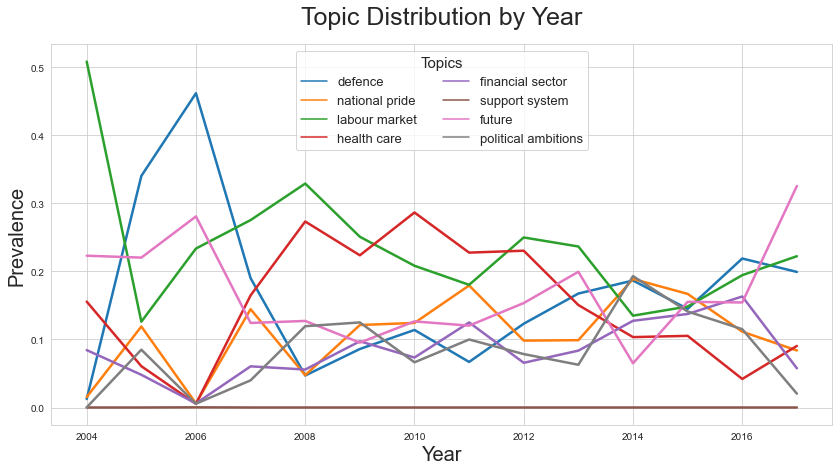

In [43]:
# plot topic distribution by year
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [14, 7]
topics_by_year = sns.lineplot(data = topic_distribution_df_melt, x = "year", y = "prevelance", hue = "topic",
                              linewidth = 2.5)
topics_by_year.set_xlabel("Year", fontsize = 20)
topics_by_year.set_ylabel("Prevalence", fontsize = 20)
plt.legend(ncol = 2, loc = 'upper center', fontsize = 13, title = "Topics", title_fontsize = 15, markerscale = 1.5)
plt.title('Topic Distribution by Year', fontsize = 25, pad = 20)
plt.show()

# Topic Prediction

## Predictors

In [44]:
# compute average topic distribution per month
df_merged['month_year'] = df_merged['date'].dt.to_period('M')
topic_distributions_monthly = df_merged.groupby('month_year', as_index = False)[topic_names].mean().copy()

# transform topic proportions to percentage points
topic_distributions_monthly.iloc[:, 1:8] = topic_distributions_monthly.iloc[:, 1:8] * 100

# convert date format
topic_distributions_monthly['month_year'] = topic_distributions_monthly['month_year'].dt.strftime('%Y-%m').add('-01')

In [45]:
# import monthly unemployment data
unemployment = pd.read_excel("other_data/unemployment_rate.xls", skiprows=10)
unemployment = unemployment.rename(columns={'UNRATE': 'unemployment', 'observation_date': 'month_year'})
unemployment = unemployment[(unemployment['month_year'] >= '2004-07-01') & (unemployment
                                                                    ['month_year'] <= '2017-01-01')]
unemployment['month_year'] = unemployment['month_year'].dt.strftime('%Y-%m-%d')

In [46]:
# import daily oil price data
oil = pd.read_csv("other_data/oil_prices.csv", skiprows = 6, parse_dates = ['Day'])
oil = oil.rename(columns = {'Europe Brent Spot Price FOB $/bbl': 'Brent', 
                          'Cushing OK WTI Spot Price FOB $/bbl': 'Cushing'})

# convert date format
oil['Day'] = pd.to_datetime(oil['Day'])
oil['month_year'] = oil['Day'].dt.to_period('M')
oil['month_year'] = oil['month_year'].dt.strftime('%Y-%m').add('-01')

# compute average monthly oil price
oil = oil.groupby('month_year', as_index = True)['Brent', 'Cushing'].mean().copy()
oil['oil'] = oil.mean(axis = 1)

# drop irrelevant columns
oil = oil.drop(['Brent', 'Cushing'], 1)

In [47]:
# import daily Dow Jones stock market data
stocks = pd.read_csv("other_data/HistoricalPricesDowJones.csv", usecols = ['Date', ' Close'], 
                     parse_dates = ['Date'])
stocks = stocks.rename(columns = {' Close': 'stocks'})

# convert date format
stocks['month_year'] = stocks['Date'].dt.to_period('M')
stocks['month_year'] = stocks['month_year'].dt.strftime('%Y-%m').add('-01')

# compute average monthly stock market index
stocks = stocks.groupby('month_year', as_index = True)['stocks'].mean().copy()

In [48]:
# merge data frames
data_frames = [topic_distributions_monthly, unemployment, oil, stocks]
time_series_df = reduce(lambda left, right: pd.merge(left, right, on = ['month_year'],
                                            how = 'inner'), data_frames)

# replace index with dates
time_series_df.index = pd.DatetimeIndex(time_series_df.month_year)
time_series_df.sort_index(inplace = True)
time_series_df = time_series_df.drop('month_year', 1)

time_series_df.astype(float).round(2).head(10)

,defence,national pride,labour market,health care,financial sector,support system,future,political ambitions,unemployment,oil,stocks
month_year,,,,,,,,,,,
2004-07-01,1.25,1.54,50.86,15.57,8.44,0.00,22.32,0.00,5.5,39.50,10152.09
2005-01-01,66.63,0.07,19.25,0.06,9.11,0.00,4.82,0.00,5.3,45.67,10539.51
2005-04-01,37.00,21.21,0.04,0.02,0.02,0.00,0.03,0.42,5.2,52.43,10283.19
2005-06-01,5.49,0.01,22.88,30.19,14.84,0.00,25.91,0.01,5.0,55.35,10486.68
2005-10-01,7.95,0.05,17.36,0.04,0.05,0.00,74.51,0.00,5.0,60.40,10324.31
2005-12-01,53.16,38.21,3.56,0.04,0.05,0.00,4.93,0.00,4.9,58.13,10827.79
2006-01-01,0.15,0.09,44.83,0.08,0.09,0.00,54.68,0.00,4.7,64.24,10872.48
2006-07-01,92.26,1.12,1.92,0.99,1.12,0.05,1.50,0.01,4.7,74.04,11032.53
2007-01-01,38.57,0.08,19.34,16.36,1.41,0.00,20.18,0.04,4.6,54.09,12512.89


## Time Series Analysis

In [49]:
# create train and test data
test_size = int(len(time_series_df) * 0.2)
train, test = time_series_df.iloc[:-test_size], time_series_df.iloc[-test_size:]

# standardise train data
def standardise_predictors(data):
    data = (data - data.mean()) / (data.std())
    return data

train_standardised = train.copy()
train_standardised.iloc[:, number_topics:] = standardise_predictors(train_standardised.iloc[:, number_topics:])

# standardise test data using train mean and train std
test_standardised = test.copy()
test_standardised.iloc[:, number_topics:] = (test_standardised.iloc[:, number_topics:] - train.iloc[:, number_topics:].
                                                      mean()) / (train.iloc[:, number_topics:].std())


### Model Taining

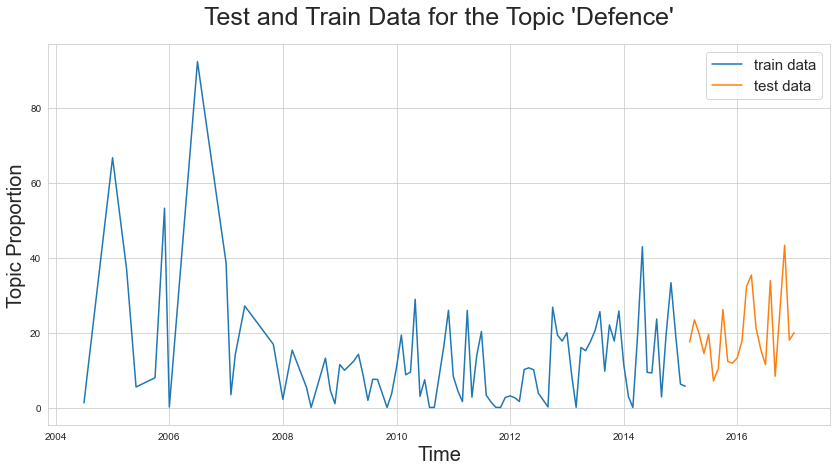

In [50]:
# plot test and train data for first topic (defence)
first_topic = topic_names[0]

fig, ax = plt.subplots(1, 1, figsize=(14, 7))
ax.plot(train_standardised[first_topic], label = "train data")
ax.plot(test_standardised[first_topic], label = "test data")
plt.xlabel("Time", fontsize = 20)
plt.ylabel("Topic Proportion", fontsize = 20)
plt.legend(loc = "upper right", fontsize = 15)
plt.title("Test and Train Data for the Topic '" + first_topic.title() + "'", fontsize = 25, pad = 20)
plt.show()

In [51]:
def time_series(data_set, predictors):
    # create empty list
    models = []
    i = 0
    
    # loop through topics and run automated time series analysis
    for column in data_set.columns[:number_topics]:        
        model = pm.auto_arima(data_set[[column]] , 
                          exogenous = data_set[predictors],
                          start_p = 1, 
                          start_q = 1,
                          test = 'adf',       
                          max_p = 5,          
                          max_q = 5,          
                          m = 1,              
                          d = None,           
                          seasonal = False,   
                          start_P = 0, 
                          D = 0, 
                          trace = False,             # suppress output
                          error_action = 'ignore',
                          suppress_warnings = True, 
                          stepwise = True)
    
        # append model to list
        models.append(model)
    
        i = i + 1
        
    return models

In [52]:
# select predictors
predictors = ['unemployment', 'oil', 'stocks']

# train time series model
models_train = time_series(train_standardised, predictors)

### Forecasting

In [53]:
# forecast time series and compare to test data
def forecast_time_series(models):
    i = 0
    for model in models:
        # predict time series
        prediction, confint = model.predict(n_periods = test_size, 
                                    exogenous = test_standardised[predictors],
                                    return_conf_int = True)
    
        # create index for prediction
        index_prediction = pd.date_range(train_standardised.index[-1], periods = test_size, freq='MS')
    
        # add index to forecast and corresponding confidence interval 
        fitted_series = pd.Series(prediction, index = index_prediction)
        lower_series = pd.Series(confint[:, 0], index = index_prediction)
        upper_series = pd.Series(confint[:, 1], index = index_prediction)
    
        print("\nThis is the forecast of the topic '" + topic_names[i] + "':\n")
    
        # plot forecast
        plt.plot(time_series_df[topic_names[i]])
        plt.plot(fitted_series, color = 'red')
        plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color = 'k', 
                 alpha = .1)
        plt.title("Forecast of Topic '" + str(topic_names[i]).title() + "'", fontsize = 25, pad = 20)
        plt.show()
    
        i = i + 1


This is the forecast of the topic 'defence':



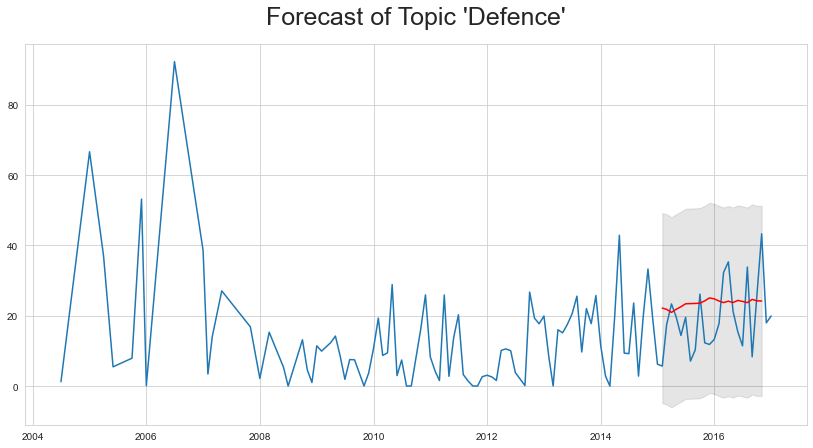


This is the forecast of the topic 'national pride':



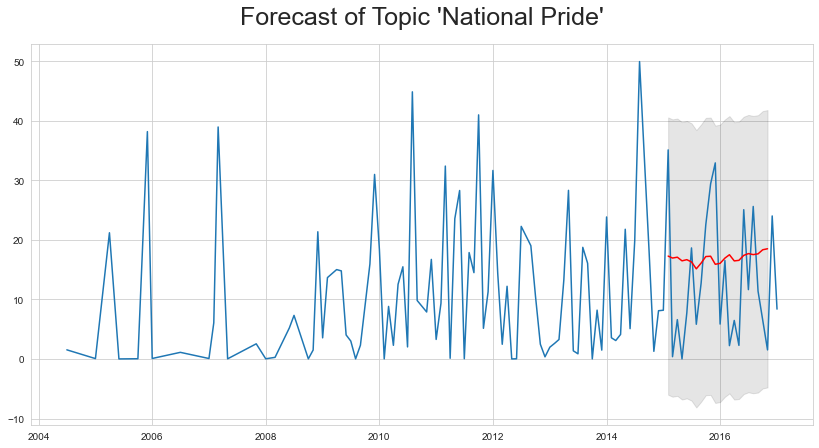


This is the forecast of the topic 'labour market':



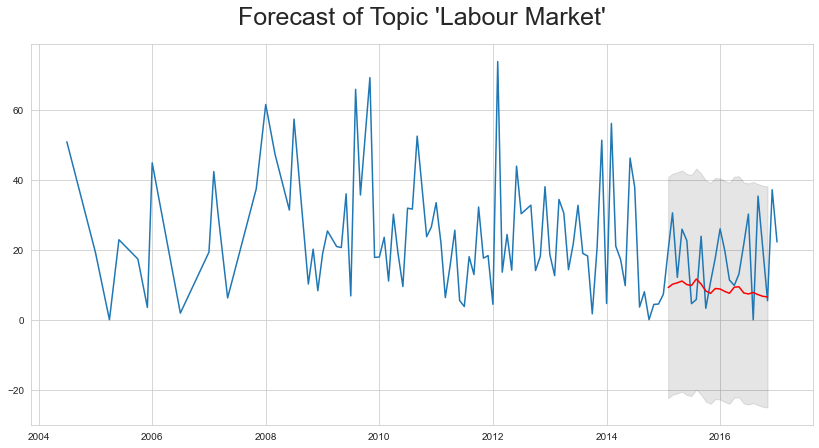


This is the forecast of the topic 'health care':



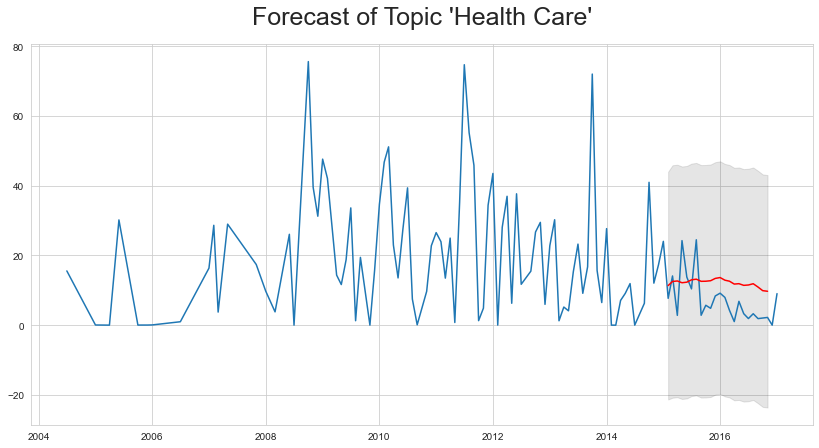


This is the forecast of the topic 'financial sector':



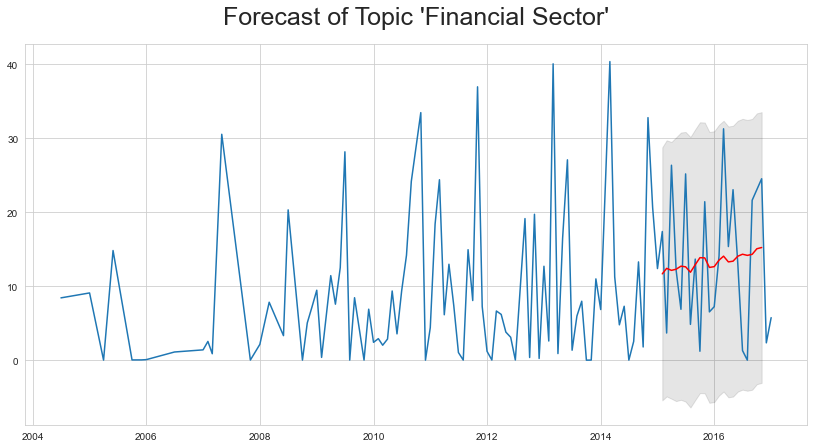


This is the forecast of the topic 'support system':



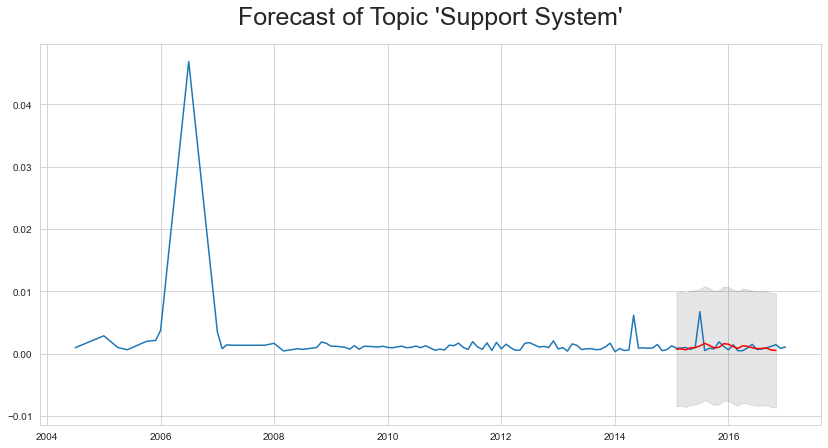


This is the forecast of the topic 'future':



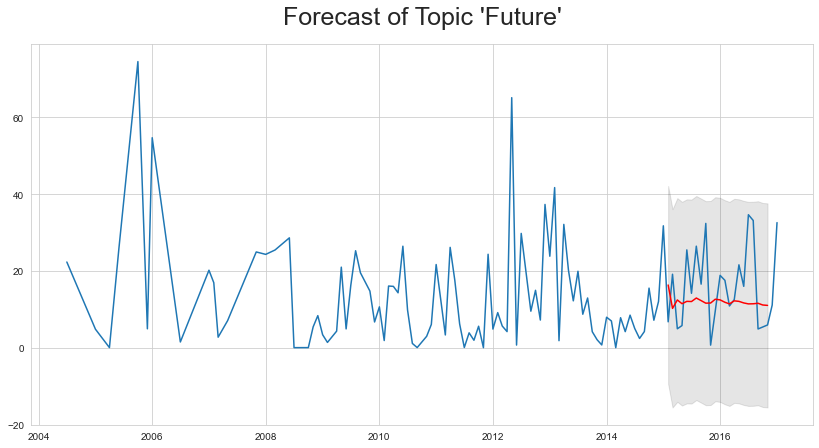


This is the forecast of the topic 'political ambitions':



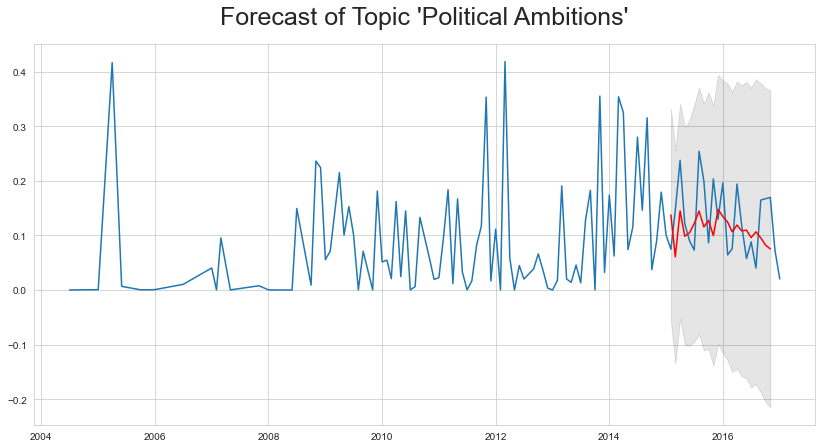

In [54]:
forecast_time_series(models_train)

### Diagnostics


These are the diagnostics plots of the topic 'defence':



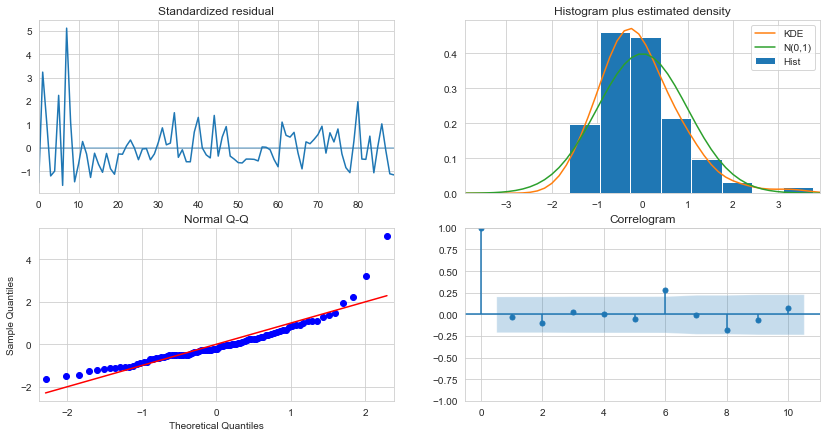


These are the diagnostics plots of the topic 'national pride':



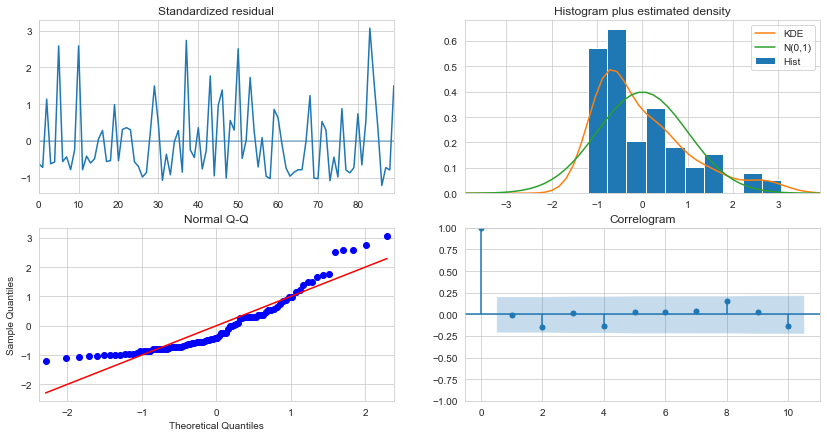


These are the diagnostics plots of the topic 'labour market':



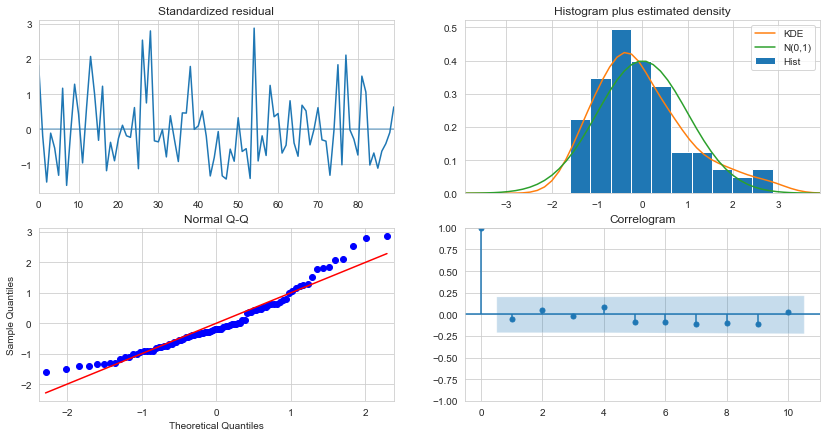


These are the diagnostics plots of the topic 'health care':



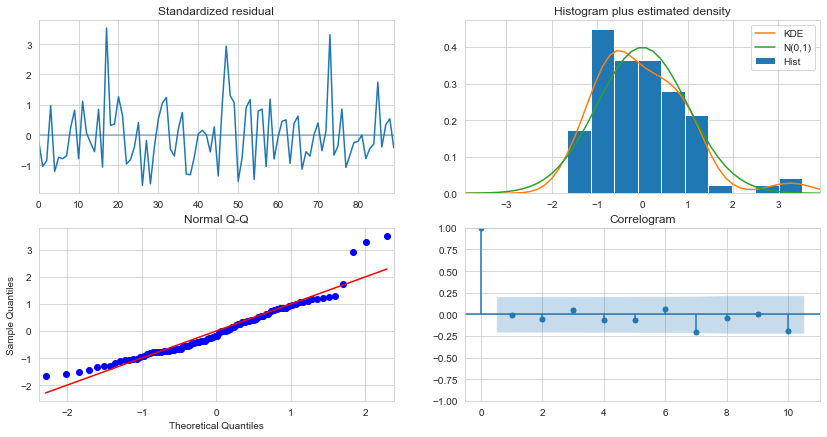


These are the diagnostics plots of the topic 'financial sector':



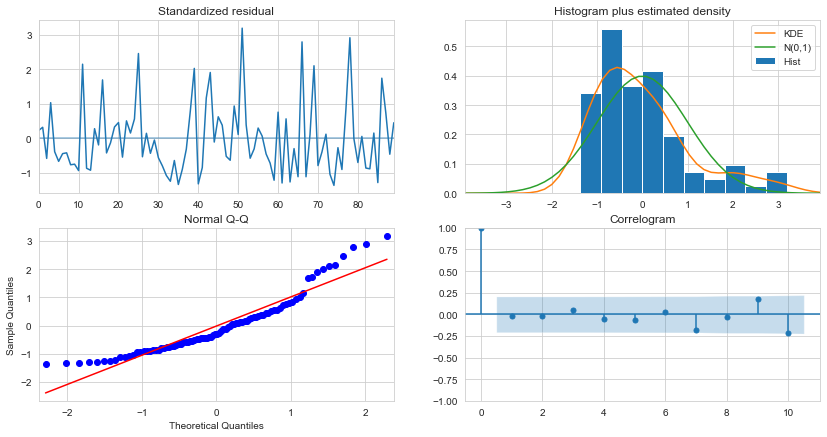


These are the diagnostics plots of the topic 'support system':



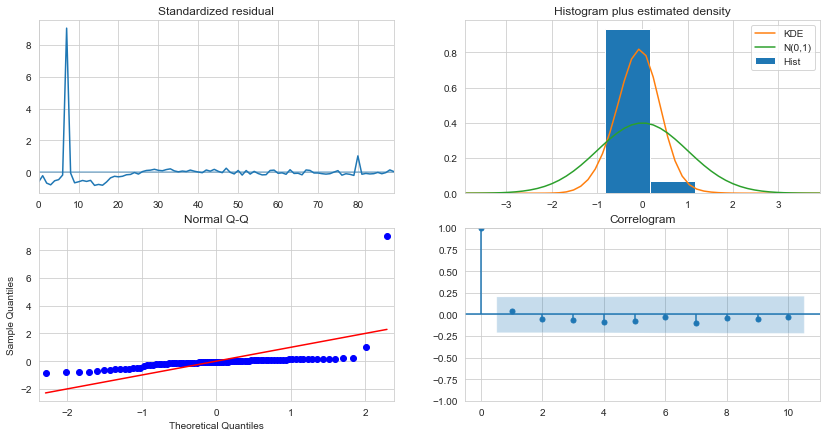


These are the diagnostics plots of the topic 'future':



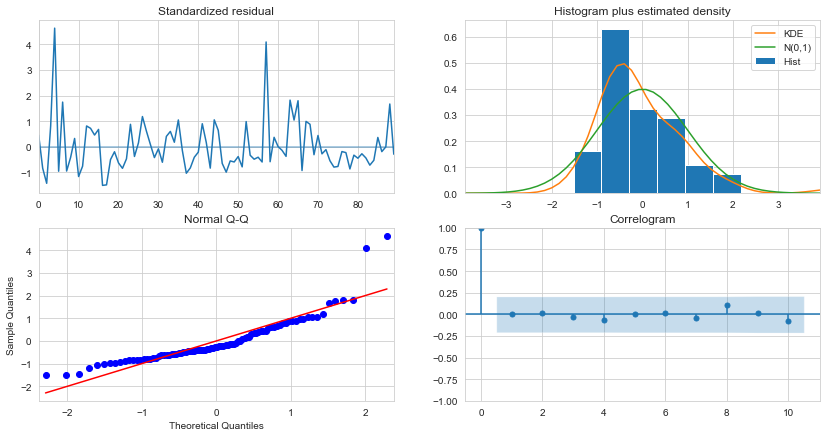


These are the diagnostics plots of the topic 'political ambitions':



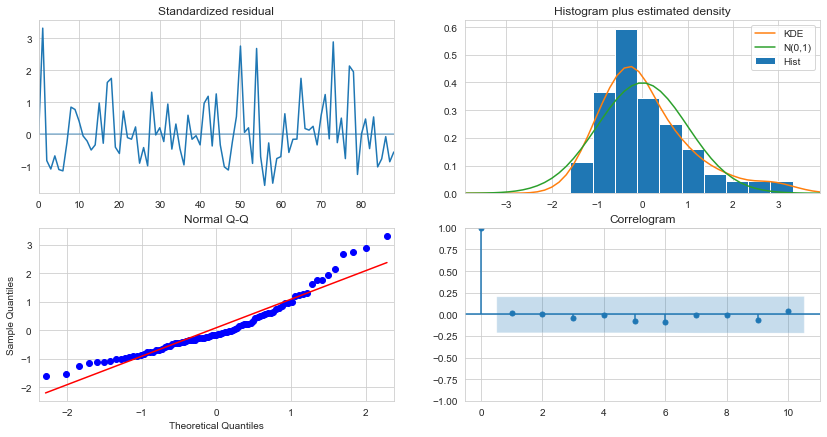

In [55]:
# show diagnostics plots for each topic
i = 0
for model in models_train:
    print("\nThese are the diagnostics plots of the topic '" + topic_names[i] + "':\n")
    model.plot_diagnostics()
    plt.show()
    i = i + 1

## Results

In [56]:
# standardise predictors in entire data set
time_series_df_standardised = time_series_df.copy()
time_series_df_standardised.iloc[:, number_topics:] = standardise_predictors(time_series_df_standardised.
                                                                             iloc[:, number_topics:])

In [57]:
# extract p, d and q from model with train data
pdq = []
for model in models_train:
    pdq.append(model.order)
    
# run time series analysis with entire data set using p, d, q from trained model
def time_series_entire(data_set, predictors):
    i = 0
    models_entire = []
    
    for column in data_set.columns[:number_topics]:
        model = ARIMA(data_set[column], 
                      order = pdq[i], 
                      exog = data_set[predictors])
    
        models_entire.append(model)
    
        i = i + 1
    
    return models_entire

In [58]:
models_entire = time_series_entire(time_series_df_standardised, predictors)

In [59]:
# extract coefficients and p-values for each topic
def coef_pvalue(models):
    i = 0
    for model in models:
        model_fit = model.fit()
        # write p-values and coefficients to data frames
        pvalues = pd.DataFrame(model_fit.pvalues)
        coef = pd.DataFrame(model_fit.params)
    
        # merge coefficients with p-values
        results = pd.merge(coef, pvalues, left_index = True, right_index = True)
        results.columns = ['coef', 'pvalues']
    
        # print output
        print("\nThis is the output of the time series analysis for the topic '" + str(topic_names[i]) + "':\n")
    
        print(results.round(4))
    
        i = i + 1

In [60]:
# print output for each topic
coef_pvalue(models_entire)


This is the output of the time series analysis for the topic 'defence':

                  coef  pvalues
const          14.6563   0.0000
unemployment   -5.0500   0.0088
oil            -0.9021   0.5714
stocks         -0.4431   0.7855
sigma2        170.2491   0.0000

This is the output of the time series analysis for the topic 'national pride':

                  coef  pvalues
const          11.6207   0.0000
unemployment    2.4470   0.1454
oil            -0.9840   0.5283
stocks          2.6456   0.0789
sigma2        133.7186   0.0000

This is the output of the time series analysis for the topic 'labour market':

                  coef  pvalues
const          22.7835   0.0000
unemployment   -1.5109   0.4140
oil             3.0899   0.0705
stocks         -3.5499   0.0616
sigma2        233.8341   0.0000

This is the output of the time series analysis for the topic 'health care':

                  coef  pvalues
const          17.3724   0.0000
unemployment    4.0323   0.1219
oil            

In [62]:
# ADD CAPTIONS

from pprint import pprint
from gensim.models import CoherenceModel
from wordcloud import WordCloud
from collections import Counter
import matplotlib.colors as mcolors
from matplotlib.ticker import FuncFormatter
import pyLDAvis
import pyLDAvis.gensim_models as LDAgensim


In [63]:
# We construct our LDA model

warnings.filterwarnings('ignore')
model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics = 6, 
                                            random_state = 100, update_every = 1, chunksize = 100, passes = 14, alpha = 'auto', per_word_topics=True) # Here we selected 5 topics
pprint(model.print_topics())
model_cor = model[corpus]

C:\Users\Balazs\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



[(0,
  '0.019*"question" + 0.013*"president_obama" + 0.010*"issue" + 0.010*"try" + '
  '0.009*"good" + 0.008*"president" + 0.007*"important" + 0.007*"happen" + '
  '0.007*"really" + 0.007*"start"'),
 (1,
  '0.016*"isil" + 0.012*"military" + 0.011*"iraq" + 0.011*"war" + '
  '0.010*"terrorist" + 0.009*"attack" + 0.008*"troop" + 0.008*"force" + '
  '0.007*"fight" + 0.007*"continue"'),
 (2,
  '0.011*"family" + 0.011*"life" + 0.009*"day" + 0.008*"love" + 0.008*"today" '
  '+ 0.008*"man" + 0.007*"give" + 0.007*"good" + 0.006*"child" + '
  '0.006*"great"'),
 (3,
  '0.014*"job" + 0.009*"economy" + 0.008*"pay" + 0.008*"business" + '
  '0.007*"plan" + 0.007*"good" + 0.005*"family" + 0.005*"company" + '
  '0.005*"health_care" + 0.005*"cost"'),
 (4,
  '0.010*"democracy" + 0.009*"believe" + 0.009*"young" + 0.007*"united_state" '
  '+ 0.007*"together" + 0.007*"today" + 0.007*"future" + 0.007*"government" + '
  '0.006*"live" + 0.006*"opportunity"'),
 (5,
  '0.016*"iran" + 0.014*"russia" + 0.010*"cont

In [66]:
# Now we calculate coherence score and perplexity

model_coher = CoherenceModel(model=model, texts=cleaned_data, dictionary=id2word, coherence='c_v')
coher_s = model_coher.get_coherence()
print('Coherence Score: ', coher_s)
print('Perplexity: ', model.log_perplexity(corpus))

Coherence Score:  0.4637736082600609
Perplexity:  -7.199481149730947


To find the most important words for each topic, we first find the dominant topics by taking the distribution of the topics per document

In [67]:
topic_dist = [model.get_document_topics(item, minimum_probability=0.0) for item in corpus]
topic_dist

[[(0, 0.00964837),
  (1, 0.02981219),
  (2, 0.64607614),
  (3, 0.17324999),
  (4, 0.14108337),
  (5, 0.00012998603)],
 [(0, 0.6888221),
  (1, 0.014755213),
  (2, 0.19680692),
  (3, 0.0006226961),
  (4, 0.09859788),
  (5, 0.00039526637)],
 [(0, 0.06672842),
  (1, 0.00015138641),
  (2, 0.3577117),
  (3, 0.37673658),
  (4, 0.19858775),
  (5, 8.415948e-05)],
 [(0, 0.13718499),
  (1, 0.00048743238),
  (2, 0.82173127),
  (3, 0.03976841),
  (4, 0.00055771245),
  (5, 0.0002702033)],
 [(0, 0.55164826),
  (1, 0.40152973),
  (2, 0.0009941633),
  (3, 0.04492517),
  (4, 0.00060853054),
  (5, 0.00029414007)],
 [(0, 0.0013980798),
  (1, 0.00092829776),
  (2, 0.99528193),
  (3, 0.0008122525),
  (4, 0.0010635698),
  (5, 0.00051586825)],
 [(0, 0.64579016),
  (1, 0.011890478),
  (2, 0.022652451),
  (3, 0.2994708),
  (4, 0.013585741),
  (5, 0.0066103768)],
 [(0, 0.42519122),
  (1, 0.00088201277),
  (2, 0.24342598),
  (3, 0.19119179),
  (4, 0.13881943),
  (5, 0.0004895346)],
 [(0, 0.016728016),
  (1, 0.075

In [68]:
top_cor = [sorted(topics, key=lambda record: -record[1])[0] for topics in topic_dist]
top_cor

[(2, 0.64607614),
 (0, 0.6888221),
 (3, 0.37673658),
 (2, 0.82173127),
 (0, 0.55164826),
 (2, 0.99528193),
 (0, 0.64579016),
 (0, 0.42519122),
 (2, 0.5217063),
 (1, 0.5105697),
 (1, 0.455271),
 (3, 0.3328801),
 (2, 0.54368734),
 (2, 0.76922363),
 (2, 0.7835919),
 (2, 0.6709771),
 (2, 0.50089),
 (4, 0.5786891),
 (3, 0.81156415),
 (2, 0.8182463),
 (3, 0.67765135),
 (3, 0.39426628),
 (3, 0.5157775),
 (1, 0.5159973),
 (3, 0.6661954),
 (3, 0.89005643),
 (2, 0.8509008),
 (2, 0.49636567),
 (3, 0.9966079),
 (0, 0.40835842),
 (3, 0.841526),
 (3, 0.5146839),
 (2, 0.7885311),
 (3, 0.7684708),
 (1, 0.70114994),
 (3, 0.72670066),
 (5, 0.3059542),
 (4, 0.4215659),
 (4, 0.45551547),
 (4, 0.52143824),
 (1, 0.5475753),
 (3, 0.89832366),
 (1, 0.4726623),
 (2, 0.76248056),
 (2, 0.50308245),
 (2, 0.4745545),
 (2, 0.5641231),
 (1, 0.546327),
 (1, 0.37717897),
 (4, 0.64733815),
 (2, 0.83369505),
 (2, 0.72193694),
 (3, 0.86144423),
 (5, 0.37147593),
 (3, 0.36035708),
 (4, 0.6079253),
 (4, 0.78809685),
 (3, 0

In [69]:
model.num_topics

6

In [70]:
topics = [[(term, round(wt, 3)) for term, wt in model.show_topic(n, topn=20)] for n in range(0, model.num_topics)]
topics

[[('question', 0.019),
  ('president_obama', 0.013),
  ('issue', 0.01),
  ('try', 0.01),
  ('good', 0.009),
  ('president', 0.008),
  ('important', 0.007),
  ('happen', 0.007),
  ('really', 0.007),
  ('start', 0.007),
  ('part', 0.006),
  ('able', 0.006),
  ('talk', 0.006),
  ('give', 0.006),
  ('fact', 0.006),
  ('problem', 0.005),
  ('even', 0.005),
  ('point', 0.005),
  ('still', 0.005),
  ('election', 0.005)],
 [('isil', 0.016),
  ('military', 0.012),
  ('iraq', 0.011),
  ('war', 0.011),
  ('terrorist', 0.01),
  ('attack', 0.009),
  ('troop', 0.008),
  ('force', 0.008),
  ('fight', 0.007),
  ('continue', 0.007),
  ('support', 0.007),
  ('afghanistan', 0.007),
  ('effort', 0.006),
  ('include', 0.006),
  ('threat', 0.006),
  ('government', 0.006),
  ('today', 0.005),
  ('security', 0.005),
  ('protect', 0.005),
  ('syria', 0.005)],
 [('family', 0.011),
  ('life', 0.011),
  ('day', 0.009),
  ('love', 0.008),
  ('today', 0.008),
  ('man', 0.008),
  ('give', 0.007),
  ('good', 0.007),


Next, we construct a dataframe matrix for the topics and keywords

In [71]:
topics_mat = pd.DataFrame([[term for term, wt in topic] for topic in topics], columns = ['Keyword '+str(i) for i in range(1, 21)],
                         index=['Topic '+str(t) for t in range(1, model.num_topics+1)]).T
topics_mat.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6
Keyword 1,question,isil,family,job,democracy,iran
Keyword 2,president_obama,military,life,economy,believe,russia
Keyword 3,issue,iraq,day,pay,young,continue
Keyword 4,try,war,love,business,united_state,united_state
Keyword 5,good,terrorist,today,plan,together,deal


The keywords per topic are now viewable

In [72]:
pd.set_option('display.max_colwidth', -1)

topics_mat = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics], columns = ['Topic Keywords'],
                         index=['Topic'+str(t) for t in range(1, model.num_topics+1)] )
topics_mat

,Topic Keywords
Topic1,"question, president_obama, issue, try, good, president, important, happen, really, start, part, able, talk, give, fact, problem, even, point, still, election"
Topic2,"isil, military, iraq, war, terrorist, attack, troop, force, fight, continue, support, afghanistan, effort, include, threat, government, today, security, protect, syria"
Topic3,"family, life, day, love, today, man, give, good, child, great, live, change, even, story, hope, young, never, together, community, still"
Topic4,"job, economy, pay, business, plan, good, family, company, health_care, cost, keep, government, even, put, reform, give, congress, money, create, today"
Topic5,"democracy, believe, young, united_state, together, today, future, government, live, opportunity, leader, history, progress, great, peace, build, change, economy, global, president"
Topic6,"iran, russia, continue, united_state, deal, china, international, security, sanction, issue, president, cooperation, region, agreement, syria, russian, europe, nuclear, ukraine, strong"


### Wordcloud

We construct a wordcloud for our LDA model from the keywords for each topic

In [130]:
# cloud = WordCloud(background_color="white", colormap="Dark2",
#                 max_font_size=150, random_state=42)
# plt.rcParams['figure.figsize'] = [20, 10]

# # We also construct subplots per topic
# for i in range(model.num_topics): # this is how many topics we show the wordclouds for

#      cloud.generate(text=topics_mat["Topic Keywords"][i])
#      plt.subplot(2, 3, i+1)
#      plt.imshow(wc, interpolation="bilinear")
#      plt.axis("off")
#      plt.title(topics_mat.index[i])

#      plt.show()

In [86]:
from collections import Counter

### Word count and word weights or significance

In [135]:
# we create the data frame for the word count and keyword weights 
tops = model.show_topics(formatted=False)
flat_data = [w for w_list in cleaned_data for w in w_list]
counts = Counter(flat_data)

output = []
for i, topic in tops:
    for word, weight in topic:
        output.append([word, i , weight, counts[word]])

df = pd.DataFrame(output, columns=['word', 'topic_id', 'weights', 'word_count'])        

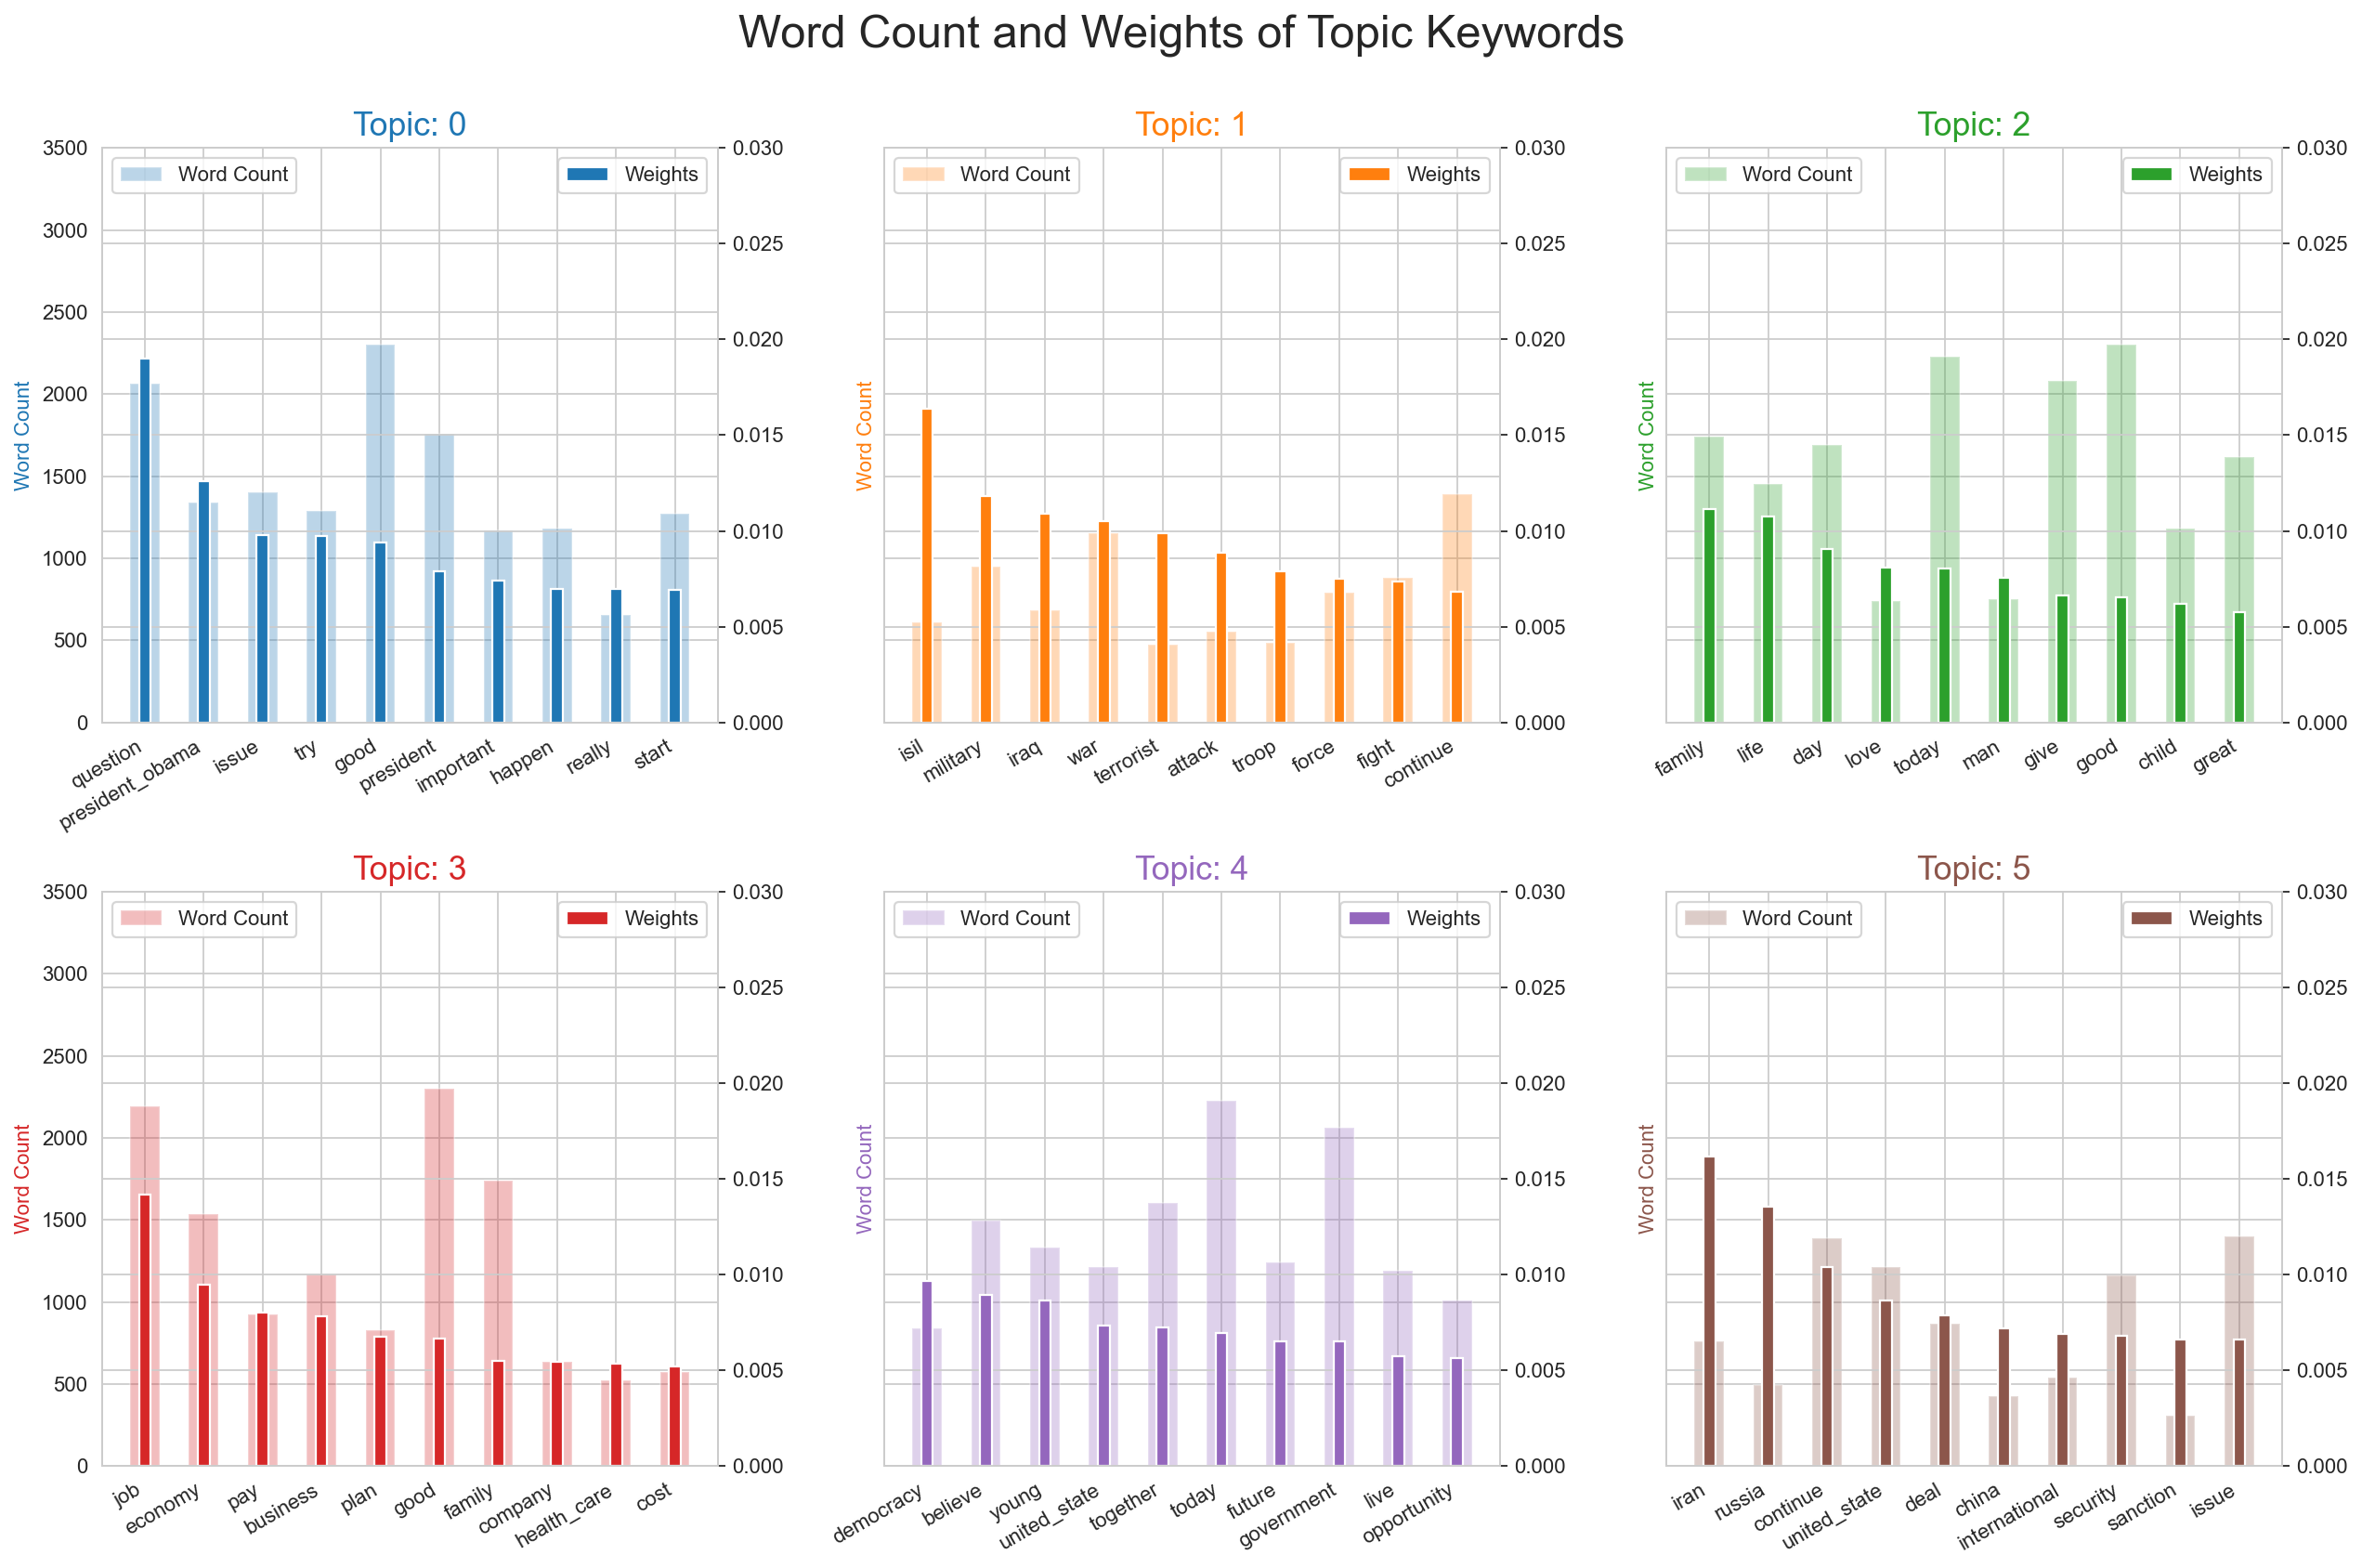

In [136]:
# now we plot the word count and the keyword weights
fig, axes = plt.subplots(2, 3, figsize=(16,10), sharey=True, dpi=160)
colors = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=colors[i], width=0.5, alpha=0.3, label='Word Count')
    axtwin = ax.twinx()
    axtwin.bar(x='word', height="weights", data=df.loc[df.topic_id==i, :], color=colors[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=colors[i])
    axtwin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=colors[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); axtwin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Weights of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

### We investigate the number of speeches corresponding to a topic

In [111]:
def speeches_per_topic (model, corpus, start=0, end=1):
    full_corpus = corpus[start:end]
    domtopics = []
    percentage_topic = []
    for i, corp in enumerate(full_corpus):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        domtopics.append((i, dominant_topic))
        percentage_topic.append(topic_percs)
    return(domtopics, percentage_topic)

domtopics, percentage_topic = speeches_per_topic(model=model, corpus=corpus, end=-1)            

# Dominant Topics per speech
df = pd.DataFrame(domtopics, columns=['Document_Id', 'Dominant_Topic'])
speech_dom_top = df.groupby('Dominant_Topic').size()
df_speech_dom_top = speech_dom_top.to_frame(name='count').reset_index()

# Distribution of topics by weight
doc_weight = pd.DataFrame([dict(t) for t in percentage_topic])
df_doc_weight = doc_weight.sum().to_frame(name='count').reset_index()

# 3 main keywords per topic
keywords3 = [(i, topic) for i, topics in model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

stacked_df_keywords3 = pd.DataFrame(keywords3, columns=['topic_id', 'words'])
df_keywords3 = stacked_df_keywords3.groupby('topic_id').agg(', \n'.join)
df_keywords3.reset_index(level=0,inplace=True)

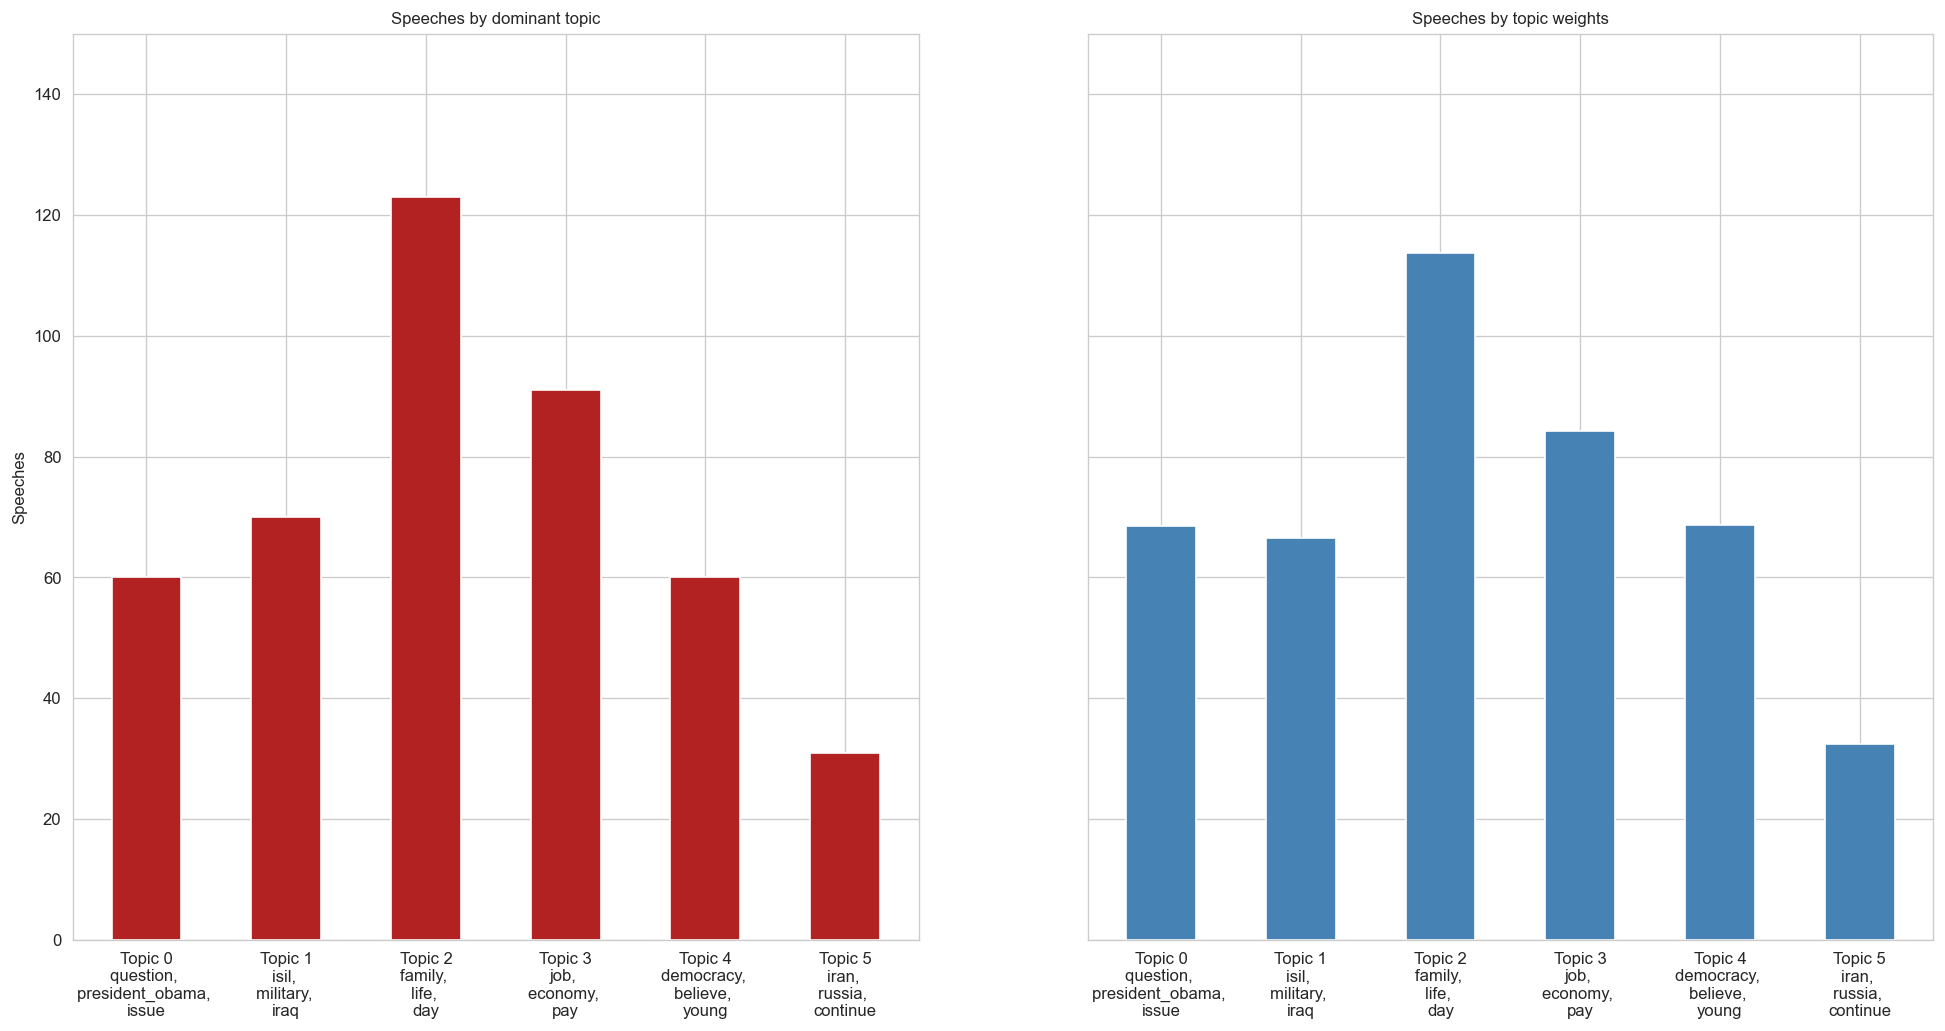

In [119]:
# Plot speeches per dominant topic
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), dpi=120, sharey=True)

# Dominant topic distribution
ax1.bar(x='Dominant_Topic', height='count', data=df_speech_dom_top, width=.5, color='firebrick')
ax1.set_xticks(range(df_speech_dom_top.Dominant_Topic.unique().__len__()))
formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_keywords3.loc[df_keywords3.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(formatter)
ax1.set_title('Speeches by dominant topic', fontdict=dict(size=10))
ax1.set_ylabel('Speeches')
ax1.set_ylim(0, 150)

# Topic weights distribution
ax2.bar(x='index', height='count', data=df_doc_weight, width=.5, color='steelblue')
ax2.set_xticks(range(df_doc_weight.index.unique().__len__()))
ax2.xaxis.set_major_formatter(formatter)
ax2.set_title('Speeches by topic weights', fontdict=dict(size=10))
plt.show()

### LDA interactive visualization

In [138]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

Shows the topics and their keywords. 

In [139]:
pyLDAvis.enable_notebook()
interactive = gensimvis.prepare(model, corpus, id2word)
interactive

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.077186 -0.100766  1       1        22.164924
0      0.006500 -0.168134  2       1        19.563164
4     -0.030278  0.070038  3       1        18.668436
2     -0.165181  0.073500  4       1        17.930621
1      0.068359  0.133035  5       1        12.586389
5      0.197786 -0.007673  6       1        9.086465 , topic_info=                 Term         Freq        Total Category  logprob  loglift
728   question         1928.000000  1928.000000  Default  30.0000  30.0000
3209  isil             956.000000   956.000000   Default  29.0000  29.0000
1250  iran             653.000000   653.000000   Default  28.0000  28.0000
2327  president_obama  1211.000000  1211.000000  Default  27.0000  27.0000
1900  russia           560.000000   560.000000   Default  26.0000  26.0000
...      ...                  ...          ...       ...      ...      ...
371   support          173.571470   1343.547915  Topic6  -5.4464   0.3519 
728   question         179.110730   1928.860906  Topic6  -5.4150   0.0217 
649   include          164.154322   1117.621540  Topic6  -5.5022   0.4802 
274   place            158.727552   1361.417137  Topic6  -5.5358   0.2493 
113   even             158.664249   2016.514473  Topic6  -5.5362  -0.1440 

[492 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
511   1      0.198294  able 
511   2      0.478395  able 
511   3      0.103148  able 
511   4      0.070248  able 
511   5      0.035568  able 
...  ..           ...   ... 
419   1      0.072136  young
419   2      0.106382  young
419   3      0.520252  young
419   4      0.293643  young
419   5      0.006558  young

[1278 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 5, 3, 2, 6])

### Speech dominant topics

In [148]:
df_cor = pd.DataFrame()
df_cor['Dominant Topic'] = [item[0]+1 for item in top_cor]
df_cor['Contribution %'] = [round(item[1]*100, 2) for item in top_cor]
df_cor['Topic Terms'] = [topics_mat.iloc[t[0]]["Topic Keywords"] for t in top_cor]

df_cor.head(5)

,Dominant Topic,Contribution %,Topic Terms
0,3,64.61,"family, life, day, love, today, man, give, good, child, great, live, change, even, story, hope, young, never, together, community, still"
1,1,68.88,"question, president_obama, issue, try, good, president, important, happen, really, start, part, able, talk, give, fact, problem, even, point, still, election"
2,4,37.67,"job, economy, pay, business, plan, good, family, company, health_care, cost, keep, government, even, put, reform, give, congress, money, create, today"
3,3,82.17,"family, life, day, love, today, man, give, good, child, great, live, change, even, story, hope, young, never, together, community, still"
4,1,55.16,"question, president_obama, issue, try, good, president, important, happen, really, start, part, able, talk, give, fact, problem, even, point, still, election"


### Percentages of dominant topics

In [150]:
import numpy as np

In [156]:
dom_df = df_cor.groupby('Dominant Topic').agg(
                                  Doc_Count = ('Dominant Topic', np.size),
                                  Total_speech_percentage = ('Dominant Topic', np.size)).reset_index()

dom_df['Total_speech_percentage'] = dom_df['Total_speech_percentage'].apply(lambda row: round((row*100) / len(corpus), 2))

dom_df.sort_values('Total_speech_percentage')

,Dominant Topic,Doc_Count,Total_speech_percentage
5,6,31,7.11
0,1,60,13.76
4,5,60,13.76
1,2,70,16.06
3,4,91,20.87
2,3,124,28.44


### LDA weights by topic

In [158]:
weights = pd.DataFrame.from_records([{v: k for v, k in row} for row in topic_dist])
weights.columns = ['Topic ' + str(i) for i in range(1,7)]
weights

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6
0,0.009648,0.029812,0.646076,0.173250,0.141083,0.000130
1,0.688822,0.014755,0.196807,0.000623,0.098598,0.000395
2,0.066728,0.000151,0.357712,0.376737,0.198588,0.000084
3,0.137185,0.000487,0.821731,0.039768,0.000558,0.000270
4,0.551648,0.401530,0.000994,0.044925,0.000609,0.000294
...,...,...,...,...,...,...
431,0.102538,0.060149,0.412216,0.082003,0.343032,0.000062
432,0.125933,0.044346,0.829055,0.000226,0.000296,0.000143
433,0.121088,0.000233,0.871357,0.006924,0.000268,0.000130
434,0.655151,0.000081,0.094283,0.000071,0.136510,0.113904


In [160]:
#df2 = speech.copy()

NameError: name 'speech' is not defined

In [ ]:
#df2['year'].reset_index(drop=True)

In [ ]:
#weights['year'] = df2.year.reset_index(drop=True)

In [ ]:
#weights.head(5)

In [ ]:
#weights['prevalent'] = weights.drop('year', axis=1).idxmax(axis=1)

In [ ]:
#weights.head(8)

In [ ]:
#weights.groupby('year')['prevalent'].value_counts(normalize=True)

In [ ]:
#weight_dominance = weights.groupby('year')['prevalent'].value_counts(normalize=True).unstack().fillna(0)
#weight_dominance

### LDA Topic Distribution from 2004 to 2016

In [ ]:
#weight_dom_year = weights.groupby('year')['prevalent'].value_counts(normalize=True).unstack().fillna(0).reset_index().copy()
#weight_dom_year.head(5)

In [ ]:
#weight_melted_year = weight_dom_year.melt(id_vars= 'year' , value_vars=['Topic ' + str(i) for i in [1,2, 3, 4, 5, 6]], var_name='Topic', value_name='prevelance')
#weight_melted_year

### ???

In [ ]:
#weight_melted_year.to_excel("/Users/fazek/OneDrive/Asztali gép/mda 2022/topic_trend.xlsx")

In [ ]:
#sns.set_style("whitegrid")
#_ = sns.lineplot(data=df_melted_year, x="year", y="prevelance", hue="Topic", style="Topic", palette='Dark2')